#%% [markdown]

 ## Log-odds regression: experiment features → choice behavior

In [ ]:
#%% [code]

# Includes

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from load_data import load_data_for_experiment, UNIQUE_CHOICE_COLUMNS, UNIQUE_CHOICE_COLUMNS_NO_UNCUED

np.set_printoptions(suppress=True, precision=3)

In [ ]:
#%% [code]

# Configuration

# Experiment versions to include (all except V0.1 and V0.2)
THREE_TASK_VERSIONS = ["V0.3_pilot", "V0.4_pilot", "V0.5_pilot", "V0.6_pilot",
                       "V0.7_pilot", "V0.8_pilot", "V0.9_pilot", "V1.0_pilot",
                       "V1.1_pilot", "V1.3_pilot"]
TWO_TASK_VERSIONS = ["V1.2_pilot", "V1.4_pilot", "V1.5_pilot", "V1.6_pilot"]
ALL_VERSIONS = THREE_TASK_VERSIONS + TWO_TASK_VERSIONS

# Pairwise log-odds contrasts (numerator, denominator)
LOG_ODDS_PAIRS = [
    ("gpi zero", "policy reuse max rew. test"),
    ("gpi zero", "mb/gpi"),
    ("policy reuse max rew. test", "mb/gpi"),
    ("policy reuse max rew. test", "policy reuse min rew. test"),
]

# Predictor columns from experiment_versions_summary.csv
PREDICTOR_COLUMNS = [
    "n_tasks",
    "n_blocks",
    "train_trials_per_block",
    "grid_states",
    "total_trajectories",
    "design_type",
    "max_pellets",
]

# Pseudocount added to proportions before computing log-odds
PSEUDOCOUNT = 0.1

In [ ]:
#%% [code]

# Load subject-level counts and experiment-level features

# Load experiment metadata
meta = pd.read_csv("results/experiment_versions_summary.csv")
meta = meta.rename(columns={"version": "experiment_version"})
# Add _pilot suffix to match version strings
meta["experiment_version"] = meta["experiment_version"] + "_pilot"
meta = meta[meta["experiment_version"].isin(ALL_VERSIONS)]

# Load subject-level data for each experiment
rows = []
for version in ALL_VERSIONS:
    choice_cols = UNIQUE_CHOICE_COLUMNS if version in THREE_TASK_VERSIONS else UNIQUE_CHOICE_COLUMNS_NO_UNCUED
    data = load_data_for_experiment(version, choice_columns=choice_cols)
    counts = data["df_counts"]
    random_choice = int(data["df_all"]["random choice"].iloc[0])

    for i in range(len(counts)):
        row = {"experiment_version": version, "subject": i, "random_choice": random_choice}
        for col in counts.columns:
            row[col] = counts.iloc[i][col]
        rows.append(row)

df_subjects = pd.DataFrame(rows)

# Merge with experiment metadata
df = df_subjects.merge(meta, on="experiment_version", how="left")

print(f"Total subjects: {len(df)}")
print(f"Experiments: {df['experiment_version'].nunique()}")
print(df.groupby("experiment_version").size())

Total subjects: 561
Experiments: 14
experiment_version
V0.3_pilot    29
V0.4_pilot    26
V0.5_pilot    26
V0.6_pilot    29
V0.7_pilot    24
V0.8_pilot    22
V0.9_pilot    30
V1.0_pilot    27
V1.1_pilot    28
V1.2_pilot    88
V1.3_pilot    17
V1.4_pilot    71
V1.5_pilot    77
V1.6_pilot    67
dtype: int64


In [ ]:
#%% [code]

# Compute log-odds for each contrast

for num_col, den_col in LOG_ODDS_PAIRS:
    # Normalize counts to proportions, add pseudocount
    num = df[num_col] / df["random_choice"] + PSEUDOCOUNT
    den = df[den_col] / df["random_choice"] + PSEUDOCOUNT
    col_name = f"logodds_{num_col}_vs_{den_col}".replace(" ", "_").replace(".", "").replace("/", "_")
    df[col_name] = np.log(num / den)

logodds_columns = [c for c in df.columns if c.startswith("logodds_")]
print("Log-odds columns:")
for c in logodds_columns:
    print(f"  {c}: mean={df[c].mean():.3f}, std={df[c].std():.3f}")

Log-odds columns:
  logodds_gpi_zero_vs_policy_reuse_max_rew_test: mean=-0.099, std=1.117
  logodds_gpi_zero_vs_mb_gpi: mean=-0.053, std=1.188
  logodds_policy_reuse_max_rew_test_vs_mb_gpi: mean=0.045, std=1.231
  logodds_policy_reuse_max_rew_test_vs_policy_reuse_min_rew_test: mean=0.063, std=0.843


In [ ]:
#%% [code]

# Run OLS regressions with clustered standard errors by experiment

results = {}
for logodds_col in logodds_columns:
    # Build formula
    predictors = []
    for col in PREDICTOR_COLUMNS:
        if df[col].dtype == object or col == "design_type":
            predictors.append(f"C({col})")
        else:
            predictors.append(col)
    formula = f"{logodds_col} ~ " + " + ".join(predictors)

    model = smf.ols(formula, data=df).fit(
        cov_type="cluster",
        cov_kwds={"groups": df["experiment_version"]},
    )
    results[logodds_col] = model

    print(f"\n{'='*80}")
    print(f"Dependent variable: {logodds_col}")
    print(f"{'='*80}")
    print(model.summary())


Dependent variable: logodds_gpi_zero_vs_policy_reuse_max_rew_test
                                          OLS Regression Results                                         
Dep. Variable:     logodds_gpi_zero_vs_policy_reuse_max_rew_test   R-squared:                       0.044
Model:                                                       OLS   Adj. R-squared:                  0.032
Method:                                            Least Squares   F-statistic:                     314.5
Date:                                           Tue, 03 Feb 2026   Prob (F-statistic):           1.81e-13
Time:                                                   17:04:28   Log-Likelihood:                -845.10
No. Observations:                                            561   AIC:                             1706.
Df Residuals:                                                553   BIC:                             1741.
Df Model:                                                      7                     

In [ ]:
#%% [code]

# Summary table of significant predictors

print(f"\n{'='*80}")
print("Summary of OLS significant predictors (p < 0.05)")
print(f"{'='*80}")

for logodds_col, model in results.items():
    print(f"\n{logodds_col}:")
    sig = model.pvalues[model.pvalues < 0.05]
    if len(sig) == 0:
        print("  (none)")
    else:
        for name, pval in sig.items():
            coef = model.params[name]
            print(f"  {name}: coef={coef:.4f}, p={pval:.4f}")


Summary of OLS significant predictors (p < 0.05)

logodds_gpi_zero_vs_policy_reuse_max_rew_test:
  Intercept: coef=6.3360, p=0.0000
  n_tasks: coef=-2.8870, p=0.0008
  n_blocks: coef=0.2893, p=0.0026
  train_trials_per_block: coef=0.0496, p=0.0015
  grid_states: coef=-0.3522, p=0.0000
  total_trajectories: coef=0.0705, p=0.0002
  max_pellets: coef=-0.1156, p=0.0001

logodds_gpi_zero_vs_mb_gpi:
  Intercept: coef=6.6059, p=0.0000
  n_tasks: coef=-4.5808, p=0.0000
  n_blocks: coef=0.5620, p=0.0000
  train_trials_per_block: coef=0.0997, p=0.0000
  grid_states: coef=-0.4742, p=0.0000
  total_trajectories: coef=0.1642, p=0.0000

logodds_policy_reuse_max_rew_test_vs_mb_gpi:
  C(design_type)[T.true MDP]: coef=0.1562, p=0.0373
  n_tasks: coef=-1.6938, p=0.0000
  n_blocks: coef=0.2727, p=0.0000
  train_trials_per_block: coef=0.0502, p=0.0000
  grid_states: coef=-0.1220, p=0.0000
  total_trajectories: coef=0.0937, p=0.0000
  max_pellets: coef=0.1068, p=0.0000

logodds_policy_reuse_max_rew_test_v

In [ ]:
#%% [code]

# LassoCV regression (L1 regularization with cross-validated alpha)

# Prepare design matrix: dummy-code categoricals, standardize all predictors
categorical_cols = [col for col in PREDICTOR_COLUMNS if df[col].dtype == object or col == "design_type"]
continuous_cols = [col for col in PREDICTOR_COLUMNS if col not in categorical_cols]

X = df[continuous_cols].copy()
for col in categorical_cols:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True).astype(float)
    X = pd.concat([X, dummies], axis=1)

feature_names = list(X.columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso_results = {}
for logodds_col in logodds_columns:
    y = df[logodds_col].values

    lasso = LassoCV(cv=5, random_state=0, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_results[logodds_col] = lasso

    print(f"\n{'='*80}")
    print(f"LassoCV: {logodds_col}")
    print(f"{'='*80}")
    print(f"Best alpha: {lasso.alpha_:.6f}")
    print(f"R² (train): {lasso.score(X_scaled, y):.4f}")
    print(f"\nCoefficients (standardized):")
    for name, coef in sorted(zip(feature_names, lasso.coef_), key=lambda x: -abs(x[1])):
        marker = "" if coef != 0 else " (zeroed)"
        print(f"  {name:30s}: {coef:+.4f}{marker}")


LassoCV: logodds_gpi_zero_vs_policy_reuse_max_rew_test
Best alpha: 0.058608
R² (train): 0.0268

Coefficients (standardized):
  grid_states                   : -0.1333
  n_tasks                       : -0.0000 (zeroed)
  n_blocks                      : -0.0000 (zeroed)
  train_trials_per_block        : -0.0000 (zeroed)
  total_trajectories            : -0.0000 (zeroed)
  max_pellets                   : -0.0000 (zeroed)
  design_type_true MDP          : +0.0000 (zeroed)

LassoCV: logodds_gpi_zero_vs_mb_gpi
Best alpha: 0.088285
R² (train): 0.0900

Coefficients (standardized):
  n_tasks                       : +0.1279
  grid_states                   : -0.1081
  design_type_true MDP          : -0.0641
  max_pellets                   : +0.0481
  total_trajectories            : +0.0216
  n_blocks                      : +0.0000 (zeroed)
  train_trials_per_block        : +0.0000 (zeroed)

LassoCV: logodds_policy_reuse_max_rew_test_vs_mb_gpi
Best alpha: 0.008524
R² (train): 0.1031

Coefficients

In [ ]:
#%% [code]

# Plots: bar plots with mean +/- SEM for top predictors

import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

N_TOP = 5  # number of top predictors to plot per contrast

# Bonferroni correction: n_contrasts * n_predictors (excluding intercept)
n_predictors = len(results[logodds_columns[0]].pvalues) - 1  # exclude Intercept
n_contrasts = len(logodds_columns)
n_tests = n_predictors * n_contrasts
ALPHA = 0.05 / n_tests
print(f"Bonferroni correction: {n_tests} tests, alpha = {ALPHA:.5f}")

def make_bar_plot(ax, df, logodds_col, orig_col, inset_text):
    """Helper to draw a bar plot with mean +/- SEM for a single predictor."""
    x_vals = df[orig_col]
    y_vals = df[logodds_col]
    groups = sorted(x_vals.unique())
    means = [y_vals[x_vals == g].mean() for g in groups]
    sems = [y_vals[x_vals == g].std() / np.sqrt((x_vals == g).sum()) for g in groups]
    x_pos = np.arange(len(groups))
    ax.bar(x_pos, means, yerr=sems, capsize=4, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([str(g) for g in groups])
    ax.set_xlabel(orig_col)
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')

    # Pairwise t-tests between adjacent and skip-1 bars
    y_max = max(m + s for m, s in zip(means, sems))
    y_min = min(m - s for m, s in zip(means, sems))
    bracket_h = (y_max - y_min) * 0.08
    pairs = [(i, i + 1) for i in range(len(groups) - 1)]
    pairs += [(i, i + 2) for i in range(len(groups) - 2)]
    for level, (i, j) in enumerate(pairs):
        g1, g2 = groups[i], groups[j]
        vals1 = y_vals[x_vals == g1].values
        vals2 = y_vals[x_vals == g2].values
        _, p_val = scipy_stats.ttest_ind(vals1, vals2)
        if p_val >= 0.05:
            label = "n.s."
        elif p_val < 0.001:
            label = "***"
        elif p_val < 0.01:
            label = "**"
        else:
            label = "*"
        y_bracket = y_max + bracket_h * (1 + level * 2.5)
        ax.plot([x_pos[i], x_pos[i], x_pos[j], x_pos[j]],
                [y_bracket - bracket_h * 0.3, y_bracket, y_bracket, y_bracket - bracket_h * 0.3],
                color='black', linewidth=0.8)
        ax.text((x_pos[i] + x_pos[j]) / 2, y_bracket, label,
                ha='center', va='bottom', fontsize=8)

    # Inset text
    ax.text(0.95, 0.95, inset_text,
            transform=ax.transAxes, ha='right', va='top', fontsize=8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    short_label = logodds_col.replace("logodds_", "log-odds: ").replace("_vs_", " / ").replace("_", " ")
    ax.set_ylabel(short_label)
    ax.set_title(f"{orig_col}")

Bonferroni correction: 28 tests, alpha = 0.00179


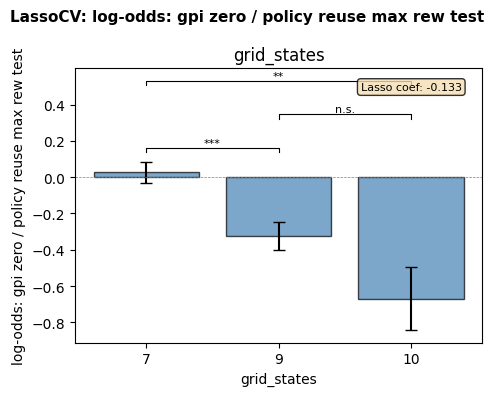

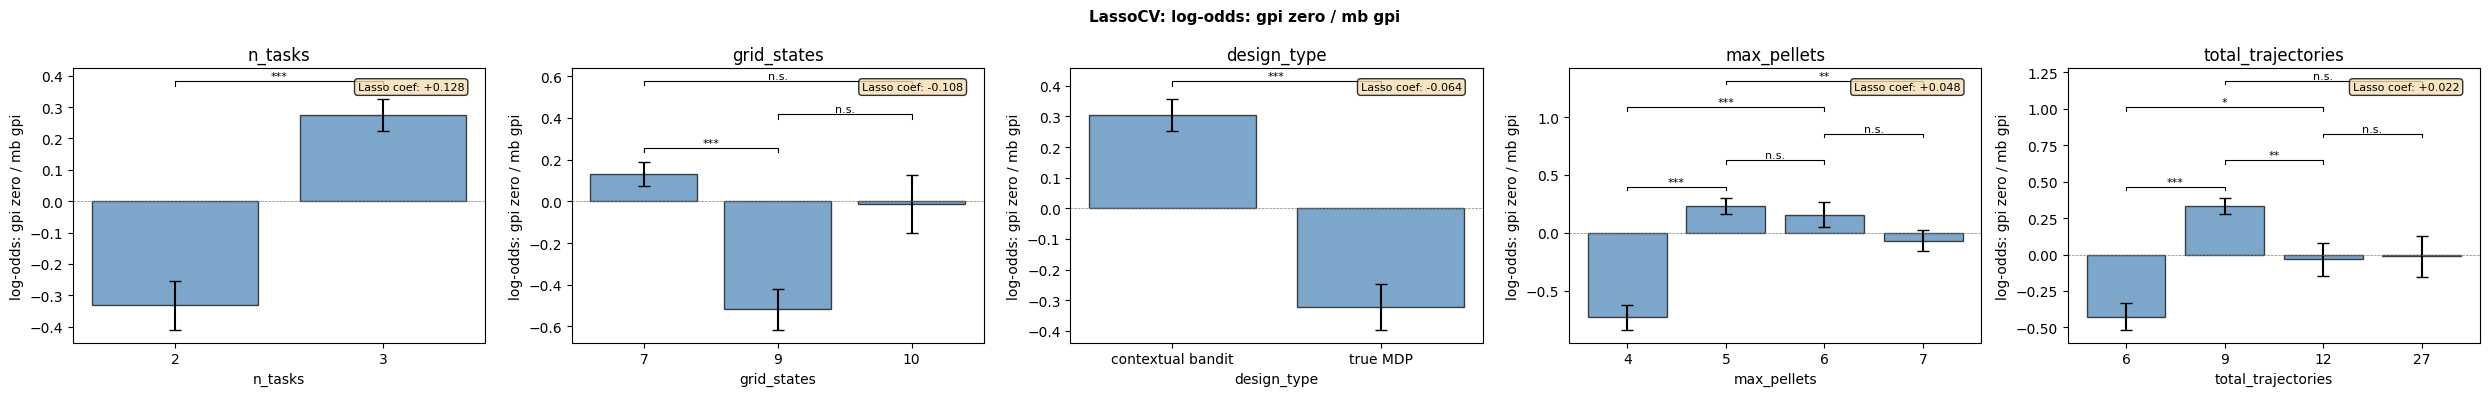

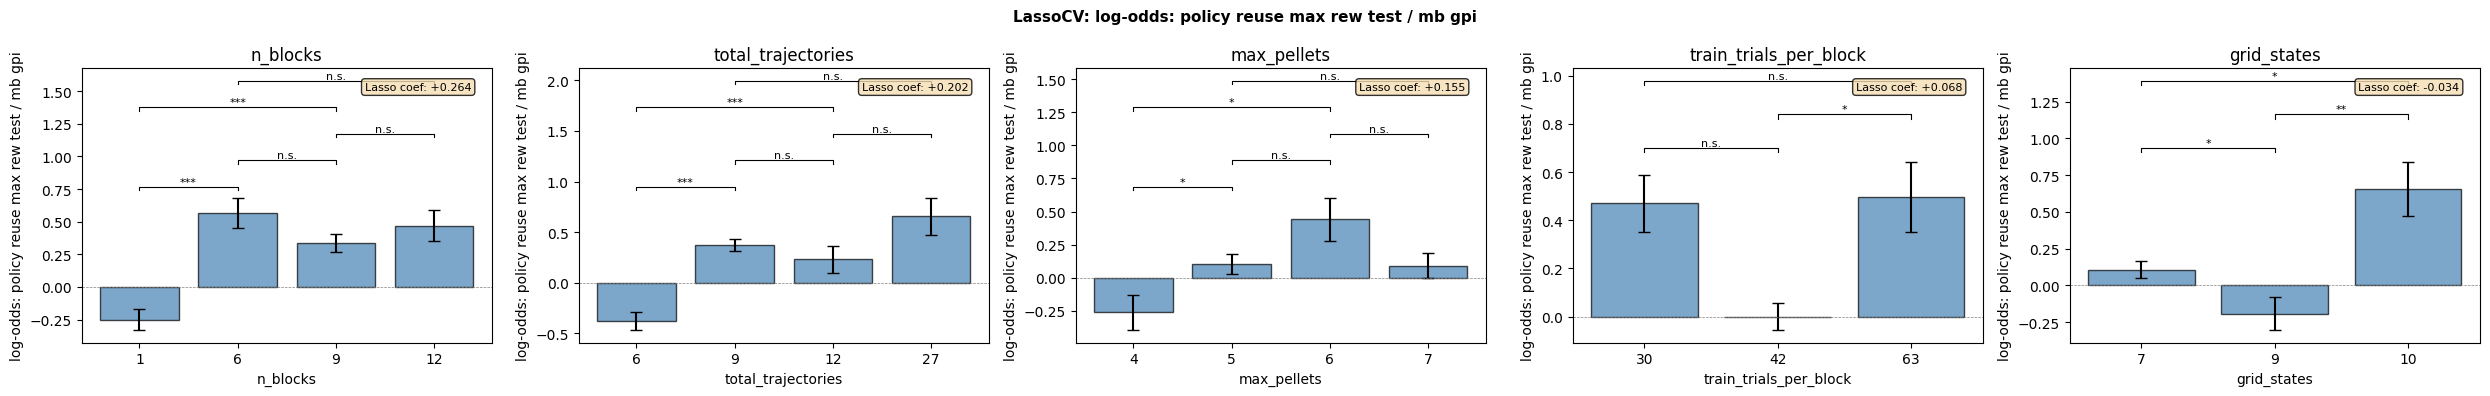

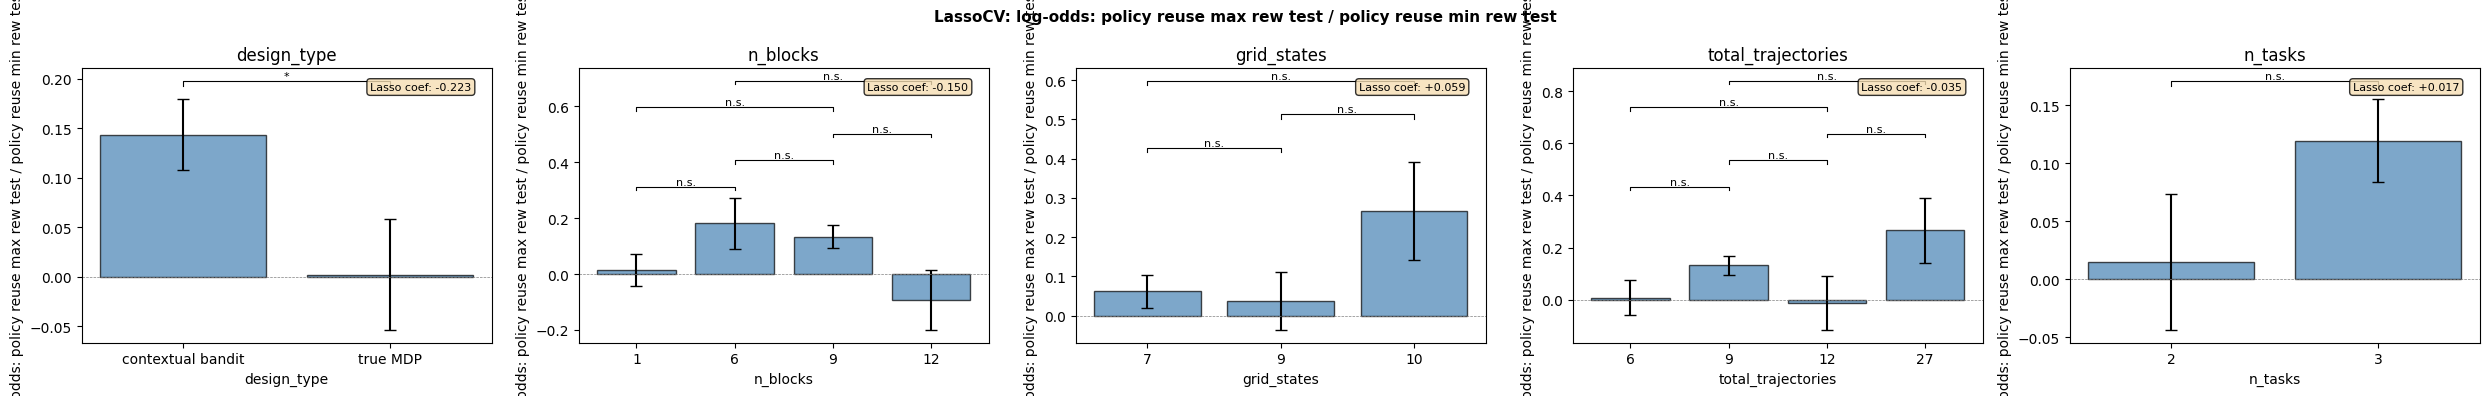

In [ ]:
#%% [code]

# --- LassoCV plots ---

for logodds_col in logodds_columns:
    lasso = lasso_results[logodds_col]
    coef_pairs = [(name, coef) for name, coef in zip(feature_names, lasso.coef_) if coef != 0]
    coef_pairs.sort(key=lambda x: -abs(x[1]))
    top_predictors = coef_pairs[:N_TOP]

    if not top_predictors:
        continue

    short_label = logodds_col.replace("logodds_", "log-odds: ").replace("_vs_", " / ").replace("_", " ")
    n_plots = len(top_predictors)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 4))
    if n_plots == 1:
        axes = [axes]

    for ax, (pred_name, pred_coef) in zip(axes, top_predictors):
        orig_col = "design_type" if pred_name.startswith("design_type_") else pred_name
        sign = "+" if pred_coef > 0 else ""
        inset = f"Lasso coef: {sign}{pred_coef:.3f}"
        make_bar_plot(ax, df, logodds_col, orig_col, inset)

    fig.suptitle(f"LassoCV: {short_label}", fontsize=11, fontweight='bold')
    fig.tight_layout()
    fig.savefig(f"results/regression_lasso_{logodds_col}.png", dpi=150, bbox_inches='tight')
    plt.show()


OLS vs Lasso: Comparing OLS (Bonferroni-corrected) and LassoCV results



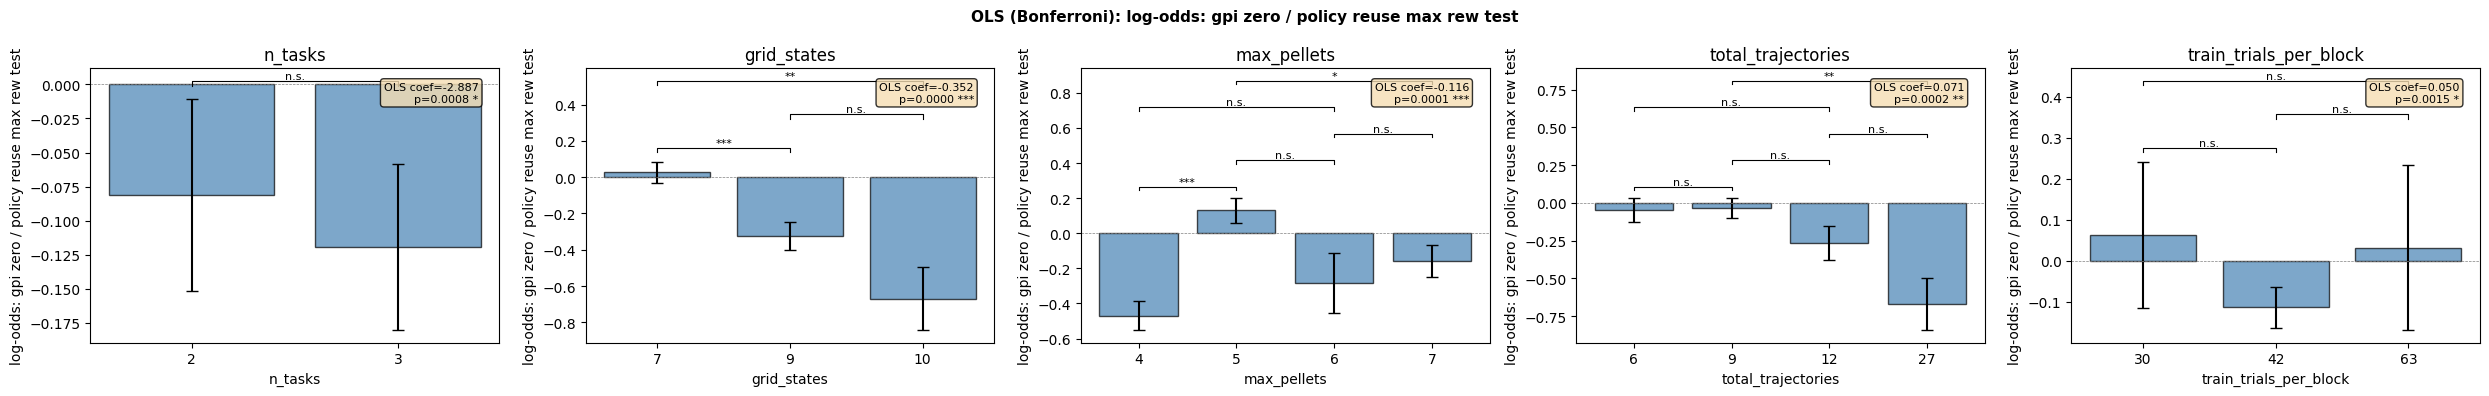

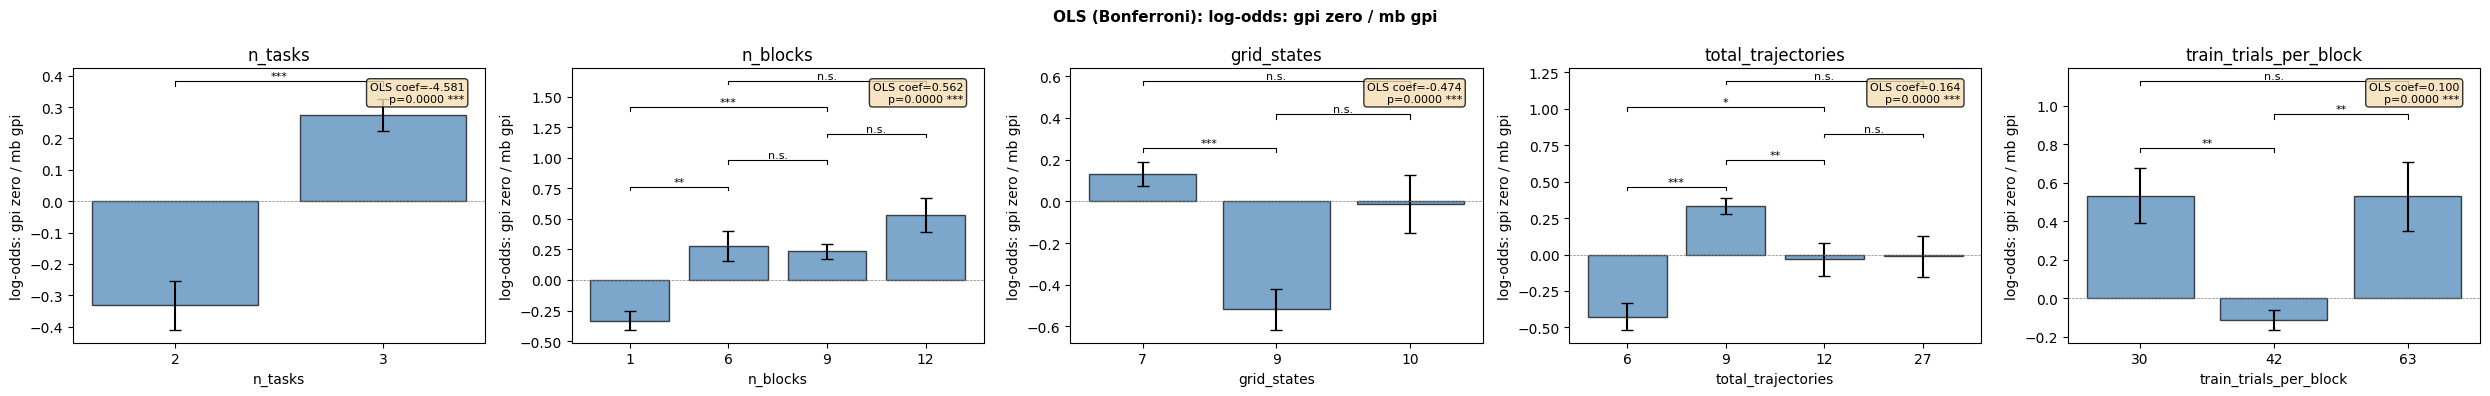

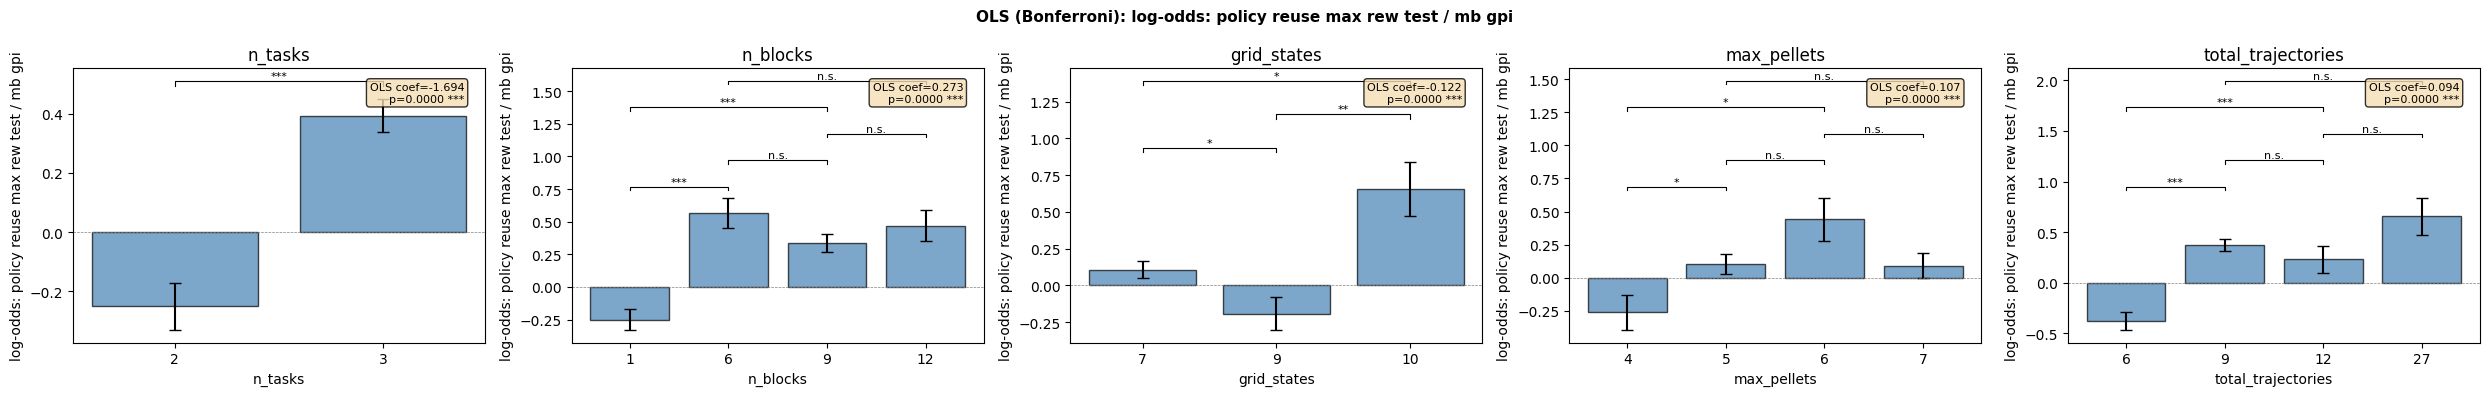

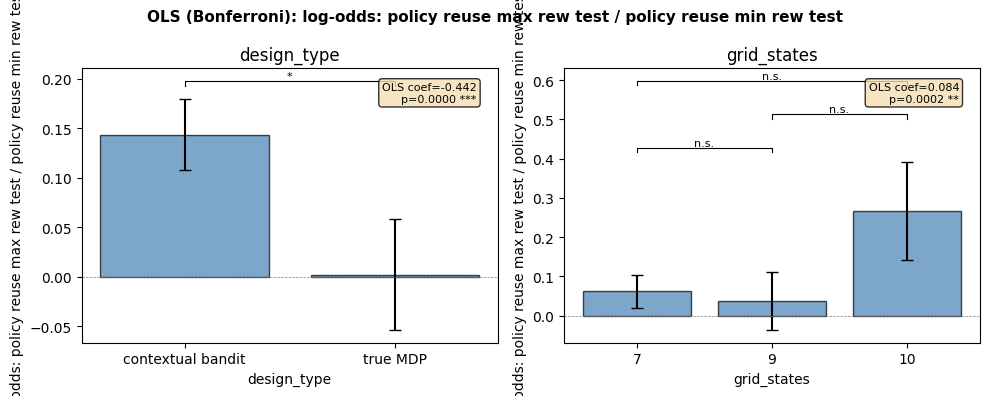

In [ ]:
#%% [code]

# --- OLS plots (Bonferroni-corrected) ---

print("\n" + "="*80)
print("OLS vs Lasso: Comparing OLS (Bonferroni-corrected) and LassoCV results")
print("="*80 + "\n")

for logodds_col in logodds_columns:
    model = results[logodds_col]
    pvals = model.pvalues.drop("Intercept")
    coefs = model.params.drop("Intercept")
    sig_names = pvals[pvals < ALPHA].index
    top_names = coefs[sig_names].abs().sort_values(ascending=False).index[:N_TOP].tolist()

    if not top_names:
        continue

    short_label = logodds_col.replace("logodds_", "log-odds: ").replace("_vs_", " / ").replace("_", " ")
    n_plots = len(top_names)
    fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 4))
    if n_plots == 1:
        axes = [axes]

    for ax, pred_name in zip(axes, top_names):
        if pred_name.startswith("C(") and pred_name.endswith("]"):
            orig_col = pred_name.split("(")[1].split(")")[0]
        else:
            orig_col = pred_name
        p = pvals[pred_name]
        c = coefs[pred_name]
        sig = "***" if p < ALPHA / 10 else "**" if p < ALPHA / 5 else "*" if p < ALPHA else ""
        inset = f"OLS coef={c:.3f}\np={p:.4f} {sig}"
        make_bar_plot(ax, df, logodds_col, orig_col, inset)

    fig.suptitle(f"OLS (Bonferroni): {short_label}", fontsize=11, fontweight='bold')
    fig.tight_layout()
    fig.savefig(f"results/regression_ols_{logodds_col}.png", dpi=150, bbox_inches='tight')
    plt.show()